Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

Training model with ReLU activation
ReLU - Epoch 10/100: Loss = 0.7499
ReLU - Epoch 20/100: Loss = 0.6086
ReLU - Epoch 30/100: Loss = 0.5414
ReLU - Epoch 40/100: Loss = 0.5008
ReLU - Epoch 50/100: Loss = 0.4658
ReLU - Epoch 60/100: Loss = 0.4444
ReLU - Epoch 70/100: Loss = 0.4184
ReLU - Epoch 80/100: Loss = 0.4081
ReLU - Epoch 90/100: Loss = 0.3895
ReLU - Epoch 100/100: Loss = 0.3791
ReLU - Test Accuracy: 81.35%

Training model with GELU activation
GELU - Epoch 10/100: Loss = 0.6177
GELU - Epoch 20/100: Loss = 0.4779
GELU - Epoch 30/100: Loss = 0.4052
GELU - Epoch 40/100: Loss = 0.3612
GELU - Epoch 50/100: Loss = 0.3248
GELU - Epoch 60/100: Loss = 0.2979
GELU - Epoch 70/100: Loss = 0.2790
GELU - Epoch 80/100: Loss = 0.2596
GELU - Epoch 90/100: Loss = 0.2492
GELU - Epoch 100/100: Loss = 0.2399
GELU - Test Accuracy: 80.98%

Training model with Softplus (β=0.5) activation
Softplus (β=0.5) - Epo

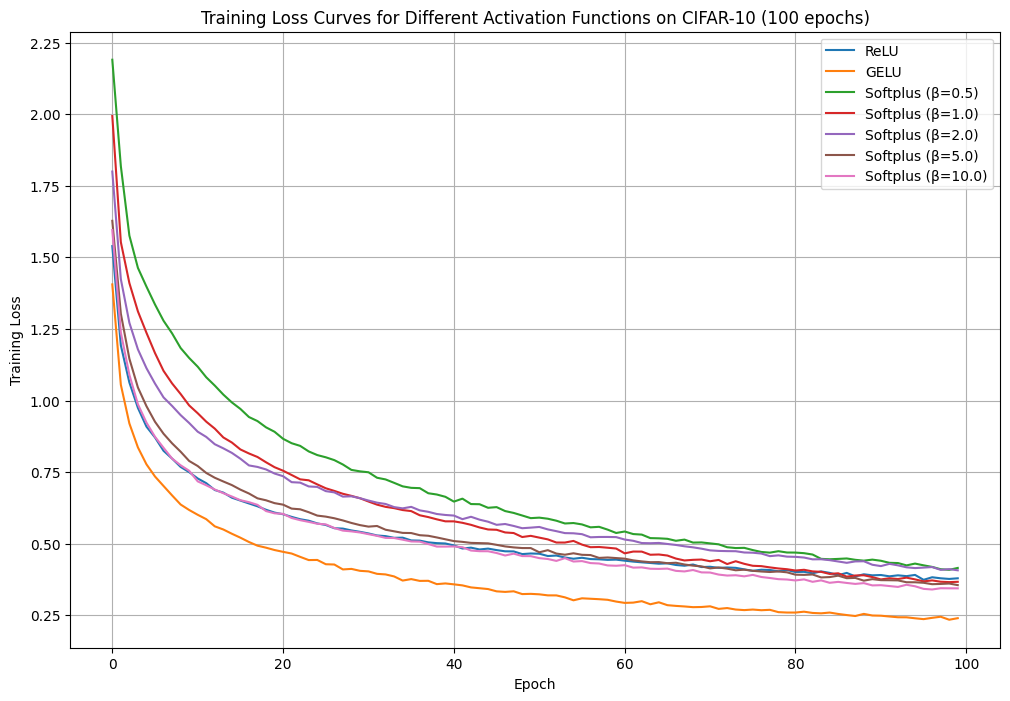


Final Test Accuracies:
ReLU: 81.35%
GELU: 80.98%
Softplus (β=0.5): 76.95%
Softplus (β=1.0): 77.98%
Softplus (β=2.0): 80.31%
Softplus (β=5.0): 80.62%
Softplus (β=10.0): 80.31%


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set the device to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define data transforms (with augmentation for training).
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 training and test datasets.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Define a simple CNN model with a parameterized activation function.
class SimpleCNN(nn.Module):
    def __init__(self, activation_fn):
        super(SimpleCNN, self).__init__()
        self.activation = activation_fn
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the activation functions to compare.
activations = {
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
    "Softplus (β=0.5)": nn.Softplus(beta=0.5),
    "Softplus (β=1.0)": nn.Softplus(beta=1.0),
    "Softplus (β=2.0)": nn.Softplus(beta=2.0),
    "Softplus (β=5.0)": nn.Softplus(beta=5.0),
    "Softplus (β=10.0)": nn.Softplus(beta=10.0)
}

# Training settings.
epochs = 100
criterion = nn.CrossEntropyLoss()

# Dictionaries to store training loss histories and test accuracies.
loss_histories = {}
test_accuracies = {}

# Loop over each activation function.
for act_name, act_fn in activations.items():
    print(f"\nTraining model with {act_name} activation")
    model = SimpleCNN(act_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(trainset)
        loss_history.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{act_name} - Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}")
    
    loss_histories[act_name] = loss_history
    
    # Evaluate the model on the test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100.0 * correct / total
    test_accuracies[act_name] = accuracy
    print(f"{act_name} - Test Accuracy: {accuracy:.2f}%")

# Plot the training loss curves for each activation function.
plt.figure(figsize=(12, 8))
for act_name, loss_history in loss_histories.items():
    plt.plot(loss_history, label=act_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Activation Functions on CIFAR-10 (100 epochs)")
plt.legend()
plt.grid(True)
plt.show()

# Print final test accuracies.
print("\nFinal Test Accuracies:")
for act_name, acc in test_accuracies.items():
    print(f"{act_name}: {acc:.2f}%")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

Training model with activation: ReLU
ReLU - Epoch [10/100]: Train Loss = 0.7464, Val Loss = 0.8308
ReLU - Epoch [20/100]: Train Loss = 0.5999, Val Loss = 0.7017
ReLU - Epoch [30/100]: Train Loss = 0.5200, Val Loss = 0.6889
ReLU - Epoch [40/100]: Train Loss = 0.4695, Val Loss = 0.6803
ReLU - Epoch [50/100]: Train Loss = 0.4348, Val Loss = 0.6682
ReLU - Epoch [60/100]: Train Loss = 0.4057, Val Loss = 0.7025
ReLU - Epoch [70/100]: Train Loss = 0.3848, Val Loss = 0.6778
ReLU - Epoch [80/100]: Train Loss = 0.3687, Val Loss = 0.6934
ReLU - Epoch [90/100]: Train Loss = 0.3500, Val Loss = 0.7103
ReLU - Epoch [100/100]: Train Loss = 0.3324, Val Loss = 0.6965
ReLU - Test Accuracy: 80.60%

Training model with activation: GELU
GELU - Epoch [10/100]: Train Loss = 0.6357, Val Loss = 0.7374
GELU - Epoch [20/100]: Train Loss = 0.4900, Val Loss = 0.7120
GELU - Epoch [30/100]: Train Loss = 0.4088, Val Loss = 

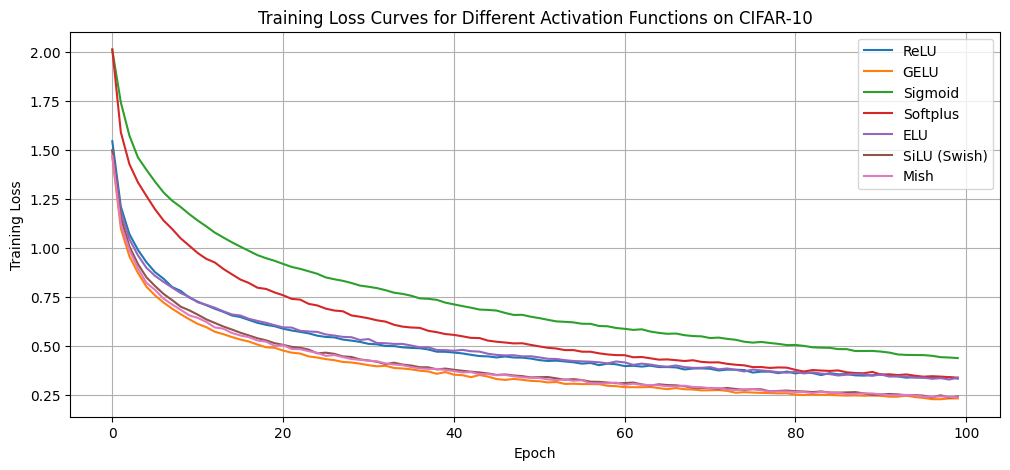

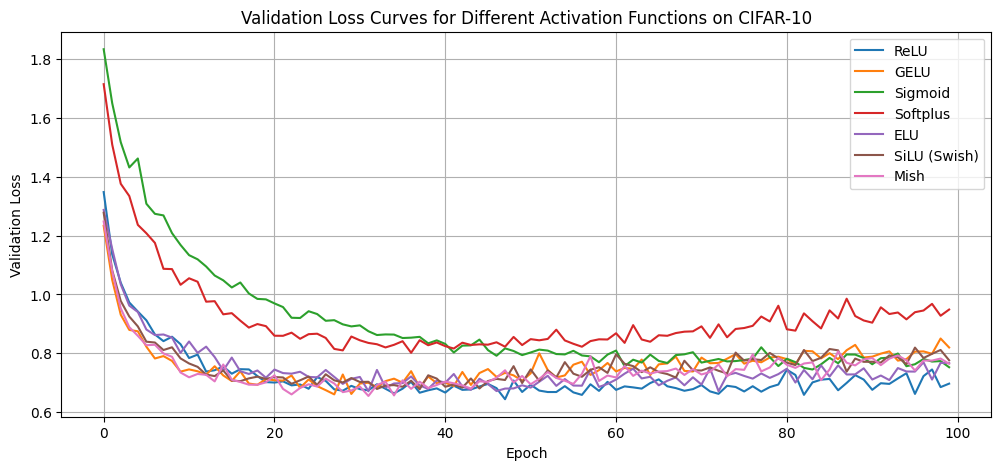


Final Test Accuracies:
ReLU: 80.60%
GELU: 80.33%
Sigmoid: 76.93%
Softplus: 76.89%
ELU: 81.20%
SiLU (Swish): 80.64%
Mish: 81.27%


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define Mish as a custom activation (Mish(x) = x * tanh(softplus(x)))
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

# Set the device: GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define data transforms for training (with augmentation) and testing.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 training and test datasets.
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split full training set into training and validation (e.g., 90% train, 10% validation).
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Define a simple CNN with one parameterized activation function.
class SimpleCNN(nn.Module):
    def __init__(self, activation_fn):
        super(SimpleCNN, self).__init__()
        self.activation = activation_fn
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define a dictionary of activation functions to compare.
activations = {
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
    "Sigmoid": nn.Sigmoid(),
    "Softplus": nn.Softplus(),
    "ELU": nn.ELU(),
    "SiLU (Swish)": nn.SiLU(),  # SiLU is PyTorch's version of Swish.
    "Mish": Mish()
}

epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# Dictionaries to store loss histories and test accuracies.
train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

# Loop over each activation function.
for act_name, act_fn in activations.items():
    print(f"\nTraining model with activation: {act_name}")
    model = SimpleCNN(act_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Evaluate on validation set.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{act_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[act_name] = train_losses
    val_loss_histories[act_name] = val_losses
    
    # Evaluate on test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100.0 * correct / total
    test_accuracies[act_name] = accuracy
    print(f"{act_name} - Test Accuracy: {accuracy:.2f}%")

# Plot training loss curves.
plt.figure(figsize=(12, 5))
for act_name, losses in train_loss_histories.items():
    plt.plot(losses, label=act_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Activation Functions on CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss curves.
plt.figure(figsize=(12, 5))
for act_name, losses in val_loss_histories.items():
    plt.plot(losses, label=act_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Activation Functions on CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()

# Print final test accuracies.
print("\nFinal Test Accuracies:")
for act_name, acc in test_accuracies.items():
    print(f"{act_name}: {acc:.2f}%")
